# Detalles sobre este notebook de python.

In [1]:
__author__ = 'Aida Nava de Wofford <awofford@astro.unam.mx>, Sundar Srinivasan <s.srinivasan@irya.unam.mx>'
__version__ = '20210421'
__datasets__ = ['SDSS']  # datos usados en este notebook
__keywords__ = ['Taller UACJ 2021', 'SDSS', 'espectro'], # palabras clave relevantes a este notebook

# Instalación de versiones necesarias de dependencias.

In [2]:
# PIP INSTALL 
!pip install --force-reinstall jsonschema==3.2.0
!pip install specutils
!pip install git+https://github.com/karllark/dust_extinction.git

# SET UP IMPORTS 
import warnings, numpy as np
warnings.filterwarnings("ignore", category = np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)
try:
  from astroquery.sdss import SDSS
except:
  !pip install astroquery
  from astroquery.sdss import SDSS

  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Using cached setuptools-59.1.1-py3-none-any.whl (951 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached attrs-21.2.0-py2.py3-none-any.whl (53 kB)
  Using cached importlib_metadata-4.8.2-py3-none-any.whl (17 kB)
  Using cached pyrsistent-0.18.0-cp37-cp37m-manylinux1_x86_64.whl (119 kB)
  Using cached zipp-3.6.0-py3-none-any.whl (5.3 kB)
  Using cached typing_extensions-4.0.0-py3-none-any.whl (22 kB)
  Attempting uninstall: zipp
    Found existing installation: zipp 3.6.0
    Uninstalling zipp-3.6.0:
      Successfully uninstalled zipp-3.6.0
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.0
    Uninstalling typing-extensions-4.0.0:
      Successfully uninstalled typing-extensions-4.0.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: setup

  Cloning https://github.com/karllark/dust_extinction.git to /tmp/pip-req-build-25uw0_5c
  Running command git clone -q https://github.com/karllark/dust_extinction.git /tmp/pip-req-build-25uw0_5c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
# Modules 

# SETUP 
RA_manual=0 # longitude in Equatorial J2000
Dec_manual=0 # latitude in Equatorial J2000

plate_manual=-1 # plate
mjd_manual=-1 # modified Julian date
fiberid_manual=-1 # fiberid

archivo_con_espectro_man = 'https://dr14.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid='+str(plate_manual)+'&mjd='+str(mjd_manual)+'&fiberid='+str(fiberid_manual)

# RETRIEVE SPECTRAL DATA 

from astropy import coordinates as coords

def retrieve_spectra(object_name):
  pos = coords.SkyCoord.from_name(object_name) #pos variable para la posición del objeto.
  tabla_sdss = SDSS.query_region(pos, spectro = True)
  plate = tabla_sdss[0][list(tabla_sdss.columns).index('plate')]
  mjd = tabla_sdss[0][list(tabla_sdss.columns).index('mjd')]
  fiberID = tabla_sdss[0][list(tabla_sdss.columns).index('fiberID')]
  sp = SDSS.get_spectra(matches = tabla_sdss, plate = plate, mjd = mjd, fiberID = fiberID)[0]
  specdata = sp[1].data
  return specdata

from astropy import units as u
from matplotlib import pyplot as plt
from specutils import Spectrum1D
from astropy.visualization import quantity_support

# Normal Plot Object
def plot_object(object_name, specdata):
  wave = 10**specdata['loglam'] * u.AA # longitud de onda
  flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') # flujo

  spec = Spectrum1D(spectral_axis=wave, flux=flux)
  quantity_support(); 

  f, ax = plt.subplots(figsize = (8, 8))
  ax.step(spec.spectral_axis, spec.flux)
  plt.xlabel('Longitud de onda ({})'.format(spec.spectral_axis.unit), fontsize = 16) 
  plt.ylabel('Flujo ({})'.format(spec.flux.unit), fontsize = 16)
  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.title('SDSS spectrum of ' + object_name, fontsize = 16);

  return spec, wave, flux

# Remove Excess Color due to Dust in our Galaxy 

from astroquery.irsa_dust import IrsaDust
from dust_extinction.parameter_averages import CCM89
from scipy.optimize import curve_fit
from specutils import Spectrum1D

ext = CCM89(Rv=3.1)

def dust_plot(object_name):
  # Adjust 
  pos = coords.SkyCoord.from_name(object_name)
  table = IrsaDust.get_extinction_table(pos)
  A_B = table['A_SandF'][table['Filter_name'] == 'CTIO B'] # extinción Galáctica en la banda B
  A_V = table['A_SandF'][table['Filter_name'] == 'CTIO V'] # extinción Galáctica en la banda V
  ebvmw = A_B - A_V # exceso de color E(B-V) de la Vía Láctea (Milky Way)

  # ebvmw = 0.1 

  uflux = flux / ext.extinguish(1/wave.to(u.micron), Ebv=ebvmw)

  # New Plot
  f, ax = plt.subplots(figsize = (8, 8))  
  ax.step(spec.spectral_axis, spec.flux, label='With Dust')
  ax.plot(wave,uflux, label='Without Dust')
  plt.xlabel('Wavelength ({})'.format(spec.spectral_axis.unit), fontsize = 16) 
  plt.ylabel('Flux ({})'.format(spec.flux.unit), fontsize = 16)
  plt.ylim(0,5e-16)
  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(loc = 'best');

  return uflux


# ADJUST FOR REDSHIFT

from astroquery.ned import Ned

def redshift_plot(object_name):
  result_table = Ned.query_object(object_name)
  z = result_table['Redshift']
  wave_rest = wave / (1 + z)

  # plot 
  f, ax = plt.subplots(figsize = (8, 8))  
  ax.plot(wave, uflux, label="Corrido al rojo")
  ax.plot(wave_rest, uflux, label="Corregido")
  plt.xlabel('Longitud de onda ({})'.format(spec.spectral_axis.unit), fontsize = 16) 
  plt.ylabel('Flujo ({})'.format(spec.flux.unit), fontsize = 16)
  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(prop = {'size': 16});

# COMBINE TO FINAL PLOT W/ ALL ADJUSTMENTS 
def combined_plot(object_name):

  # RETRIEVE SPEC DATA 
  specdata = retrieve_spectra(object_name)

  # PROCESS SPEC, WAVE, FLUX 
  wave = 10**specdata['loglam'] * u.AA # longitud de onda
  flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') # flujo
  spec = Spectrum1D(spectral_axis=wave, flux=flux)
  quantity_support(); 

  # ADJUST FOR DUST 
  ext = CCM89(Rv=3.1)
  pos = coords.SkyCoord.from_name(object_name)
  table = IrsaDust.get_extinction_table(pos)
  A_B = table['A_SandF'][table['Filter_name'] == 'CTIO B'] # extinción Galáctica en la banda B
  A_V = table['A_SandF'][table['Filter_name'] == 'CTIO V'] # extinción Galáctica en la banda V
  ebvmw = A_B - A_V # exceso de color E(B-V) de la Vía Láctea (Milky Way)
  uflux = flux / ext.extinguish(1/wave.to(u.micron), Ebv=ebvmw)

  # ADJUST FOR REDSHIFT 
  result_table = Ned.query_object(object_name)
  z = result_table['Redshift']
  wave_rest = wave / (1 + z)

  # PLOT
  f, ax = plt.subplots(figsize = (8, 8))  
  ax.plot(wave, flux, label="Original")
  ax.plot(wave_rest, uflux, label="Corrected (Dust + Redshift)")
  plt.xlabel('Wavelength ({})'.format(spec.spectral_axis.unit), fontsize = 16) 
  plt.ylabel('Flux ({})'.format(spec.flux.unit), fontsize = 16)
  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(prop = {'size': 16});
  plt.title('SDSS spectrum of '+ object_name, fontsize = 16)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: the ``irsa_dust`` module has been moved to astroquery.ipac.irsa.irsa_dust, please update your imports.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: the ``ned`` module has been moved to astroquery.ipac.ned, please update your imports.


In [4]:
print(retrieve_spectra("KISSR 298"))

[(13.479021, 3.5816, 0.06797916, 0, 0, 1.1088611 , 9.002381, 13.217207)
 (19.215475, 3.5817, 0.06977836, 0, 0, 1.108475  , 9.212716, 13.737914)
 (14.267138, 3.5818, 0.07592517, 0, 0, 1.108091  , 9.300478, 13.168895)
 ...
 ( 8.162261, 3.9645, 0.35342726, 0, 0, 0.7729795 , 4.512267, 12.689797)
 (11.752623, 3.9646, 0.        , 0, 0, 0.77300555, 4.811207, 12.891481)
 (15.343176, 3.9647, 0.28280747, 0, 0, 0.77303153, 4.932665, 12.677738)]


In [10]:
# EXPERIMENTAL LIBRARIES 
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_generic_continuum
from specutils import Spectrum1D
from astropy.modeling import models
from specutils.fitting import find_lines_derivative
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.table import vstack
from scipy.ndimage import gaussian_filter
from statistics import stdev

In [6]:
# From SkyServer SDSS - Most Common spectral lines 
Single_common_spec_lines = [
  ['Ha',6600], ['Hb',4800],['Hc',4350],
  ['G Band', 3800], ['Sodium', 4250], ['He (neutral)', 4200], ['He (ionized)', 4400]
]

   line_center    line_type line_center_index
     Angstrom                                
----------------- --------- -----------------
3729.237246651529  emission                14
3869.190092992226  emission               174
4341.302238777385  emission               674
4862.057071091152  emission              1166
4959.296369528167  emission              1252
5007.489472262782  emission              1294
6563.264097701391  emission              2469
 
 
 


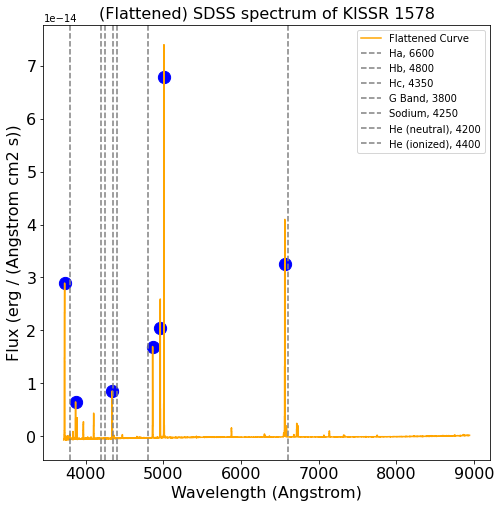

In [78]:
# Combined Processing 
def combined_process(object_name):

  # RETRIEVE SPEC DATA 
  specdata = retrieve_spectra(object_name)

  # PROCESS SPEC, WAVE, FLUX 
  wave = 10**specdata['loglam'] * u.AA # longitud de onda
  flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') # flujo
  spec = Spectrum1D(spectral_axis=wave, flux=flux)
  quantity_support(); 

  # ADJUST FOR DUST 
  ext = CCM89(Rv=3.1)
  pos = coords.SkyCoord.from_name(object_name)
  table = IrsaDust.get_extinction_table(pos)
  A_B = table['A_SandF'][table['Filter_name'] == 'CTIO B'] # extinción Galáctica en la banda B
  A_V = table['A_SandF'][table['Filter_name'] == 'CTIO V'] # extinción Galáctica en la banda V
  ebvmw = A_B - A_V # exceso de color E(B-V) de la Vía Láctea (Milky Way)
  uflux = flux / ext.extinguish(1/wave.to(u.micron), Ebv=ebvmw)

  # ADJUST FOR REDSHIFT 
  result_table = Ned.query_object(object_name)
  z = result_table['Redshift']
  wave_rest = wave / (1 + z)


  # ==> after adjustments, plot (x,y) = (wave_rest, uflux)

  # EXPERIMENTATION - RIGOROUS MODEL FOR PEAK DETECTION / AIDA's CODE ---------------------------------------------------------------------------------------------------------------

  # <reconcatenate uflux and wave rest into Spectrum1D Object>
  adjusted_spec = Spectrum1D(spectral_axis = wave_rest, flux = uflux)

  # subspec - adjust range here 
  sub_region_left = min(adjusted_spec.spectral_axis) 
  sub_region_right = max(adjusted_spec.spectral_axis)
  sub_region = SpectralRegion(sub_region_left, sub_region_right) # can adjust to get specific segment of spectra
  sub_spec= extract_region(adjusted_spec, sub_region)

  # yfit < -- fit to straight line & flatten continuum -- > 
  yfit=fit_generic_continuum(sub_spec)(sub_spec.spectral_axis) 

  # subtract continuum (flatten)
  spec_cont_sub = Spectrum1D(spectral_axis=sub_spec.spectral_axis, flux=sub_spec.flux - yfit)

  # Find spectral lines w/ flux threshold (set as 5 times standard dev of flux) 
  lines = find_lines_derivative(spec_cont_sub, flux_threshold=stdev(uflux.value)*2)
  find_flux = lambda wave_pos: spec_cont_sub.flux.value[ np.where(spec_cont_sub.spectral_axis.value == wave_pos)]
  spectral_lines = [[line['line_center'].value, find_flux(line['line_center'].value)[0], line['line_type']] for line in lines if line['line_type'] == 'emission' or line['line_type']=='absorption']


  # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

  # print emission list 
  print(lines[lines['line_type']== "emission"])
  print( ' \n \n ')

  # Current Plot 
  f, ax = plt.subplots(figsize = (8, 8))  
  ax.step(spec_cont_sub.spectral_axis, spec_cont_sub.flux, label="Flattened Curve", color="orange")

  # plot detected spectral points
  for point in spectral_lines:
    plt.scatter(point[0], point[1], s=150, color='blue')
  
  # plot most common spectra lines
  for common_line in Single_common_spec_lines:
    plt.axvline(common_line[1], ls='--', c='gray', label=common_line[0]+", " + str(common_line[1]))

  plt.xlabel('Wavelength ({})'.format(spec.spectral_axis.unit), fontsize = 16) 
  plt.ylabel('Flux ({})'.format(spec.flux.unit), fontsize = 16)
  plt.xticks(fontsize = 16)
  plt.yticks(fontsize = 16)
  plt.legend(prop = {'size': 10});
  plt.title('(Flattened) SDSS spectrum of '+ object_name, fontsize = 16)

  
combined_process("KISSR 1578")


   line_center     line_type line_center_index
     Angstrom                                 
------------------ --------- -----------------
3725.9243391865357  emission               104
 4341.442882416631  emission               768
4862.2148650542385  emission              1260
 6549.888717471879  emission              2554
 6563.476639770223  emission              2563
 6584.669162342215  emission              2577
 6717.908629669669  emission              2664
 6731.845198941444  emission              2673
 
 
 


   line_center    line_type line_center_index
     Angstrom                                
----------------- --------- -----------------
4341.380465567983  emission               655
4862.145274845378  emission              1147
5008.731909802287  emission              1276
6549.798548076207  emission              2441
6564.896001489899  emission              2451
6584.578412559973  emission              2464
6717.811944256832  emission              2551
6733.297296758708  emission              2561
 
 
 


   line_center     line_type line_center_index
     Angstrom                                 
------------------ --------- -----------------
  3729.04801915454  emission                55
 4341.081865466212  emission               715
  4861.81038773566  emission              1207
 5007.235029202716  emission              1335
 6549.347211335077  emission              2501
 6564.443884089529  emission              2511
 6584.124582113274  emission              2524
6717.3494428399035  emission              2611
 6732.836909780797  emission              2621
 
 
 


   line_center    line_type line_center_index
     Angstrom                                
----------------- --------- -----------------
3729.237246651529  emission                14
3869.190092992226  emission               174
4341.302238777385  emission               674
4862.057071091152  emission              1166
4959.296369528167  emission              1252
5007.489472262782  emission              1294
6563.264097701391  emission              2469
 
 
 


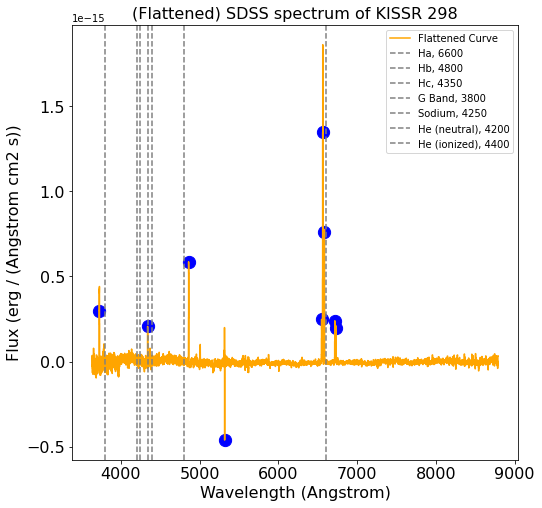

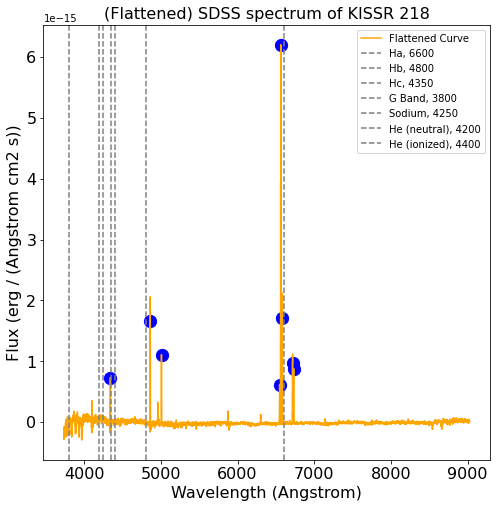

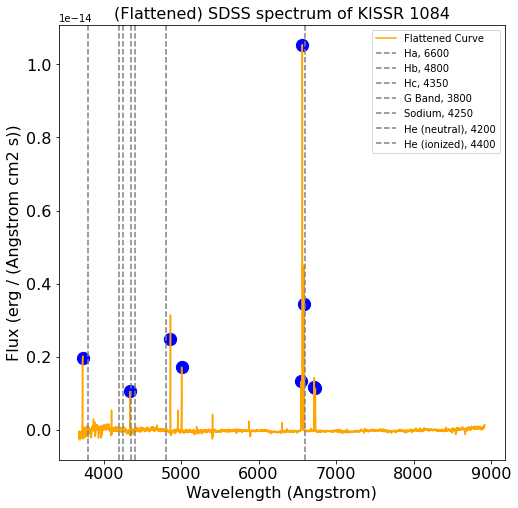

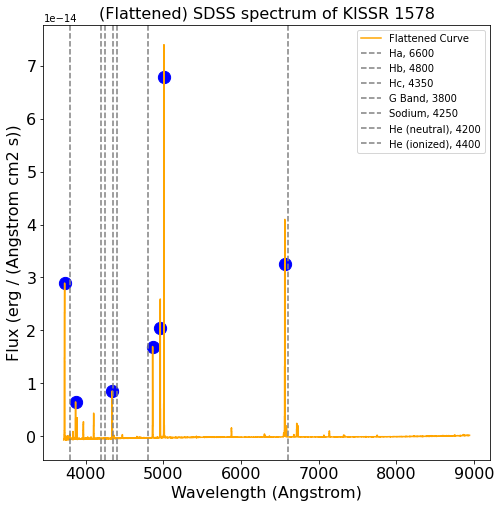

In [79]:
# Example of Scalability
KISSR_galaxies = ["KISSR 298","KISSR 218","KISSR 1084", "KISSR 1578"]
for galaxy in KISSR_galaxies:
  combined_process(galaxy)